# Spleen 3D segmentation with MONAI

This tutorial demonstrates how MONAI can be used in conjunction with the [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) framework.

We demonstrate use of the following MONAI features:
1. Transforms for dictionary format data.
2. Loading Nifti images with metadata.
3. Add channel dim to the data if no channel dimension.
4. Scaling medical image intensity with expected range.
5. Croping out a batch of balanced images based on  the positive / negative label ratio.
6. Cache IO and transforms to accelerate training and validation.
7. Use of a a 3D UNet model, Dice loss function, and mean Dice metric for a 3D segmentation task.
8. The sliding window inference method.
9. Deterministic training for reproducibility.

The training Spleen dataset used in this example can be downloaded from from http://medicaldecathlon.com//

![spleen](http://medicaldecathlon.com/img/spleen0.png)


Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

In addition to the usual MONAI requirements you will need Lightning installed.

In [ ]:
! pip install pytorch-lightning

In [17]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import sys
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import monai
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, RandCropByPosNegLabeld, \
    RandAffined, Spacingd, Orientationd, ToTensord
from monai.data import list_data_collate, sliding_window_inference
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from pytorch_lightning import LightningModule, Trainer, loggers
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

monai.config.print_config()

MONAI version: 0.1.0rc2+11.gdb4531b.dirty
Python version: 3.6.8 (default, Oct  7 2019, 12:59:55)  [GCC 8.3.0]
Numpy version: 1.18.2
Pytorch version: 1.4.0
Ignite version: 0.3.0


## Define the LightningModule

The LightningModule contains a refactoring of your training code. The following module is a refactoring of the code in `spleen_segmentation_3d.ipynb`: 

In [76]:
class Net(LightningModule):
    def __init__(self):
        super().__init__()
        self._model = monai.networks.nets.UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH)
        self.loss_function = monai.losses.DiceLoss(to_onehot_y=True, do_softmax=True)
        self.best_val_dice = 0
        self.best_val_epoch = 0

    
    def forward(self, x): 
        return self._model(x)
    
    def prepare_data(self):
        # set up the correct data path
        data_root = '/workspace/data/medical/Task09_Spleen'
        train_images = glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz'))
        train_labels = glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz'))
        data_dicts = [{'image': image_name, 'label': label_name}
                      for image_name, label_name in zip(train_images, train_labels)]
        train_files, val_files = data_dicts[:-9], data_dicts[-9:]
        
        # define the data transforms
        train_transforms = Compose([
            LoadNiftid(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0)),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
            # randomly crop out patch samples from big image based on pos / neg ratio
            # the image centers of negative samples must be in valid image area
            RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', size=(96, 96, 96), pos=1, 
                                   neg=1, num_samples=4, image_key='image', image_threshold=0),
            # user can also add other random transforms
            # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
            #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
            ToTensord(keys=['image', 'label'])
        ])
        val_transforms = Compose([
            LoadNiftid(keys=['image', 'label']),
            AddChanneld(keys=['image', 'label']),
            Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0)),
            Orientationd(keys=['image', 'label'], axcodes='RAS'),
            ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
            ToTensord(keys=['image', 'label'])
        ])
        
        # set deterministic training for reproducibility
        train_transforms.set_random_state(seed=0)
        torch.manual_seed(0)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        # we use cached datasets - these are 10x faster than regular datasets
        self.train_ds = monai.data.CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        self.val_ds = monai.data.CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
        #self.train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
        #self.val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)

    def train_dataloader(self):
        train_loader = DataLoader(self.train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=list_data_collate)
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(self.val_ds, batch_size=1, num_workers=4)
        return val_loader
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {'train_loss': loss.item()}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        value = compute_meandice(y_pred=outputs, y=labels, include_background=False,
                                 to_onehot_y=True, mutually_exclusive=True)
        return {'val_loss': loss, 'val_dice': value}
    
    def validation_epoch_end(self, outputs):
        val_dice = 0
        num_items = 0
        for output in outputs:
            val_dice += output['val_dice'].sum().item()
            num_items += len(output['val_dice'])
        mean_val_dice = val_dice / num_items
        tensorboard_logs = {'val_dice': mean_val_dice}
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print('current epoch %d current mean dice: %0.4f best mean dice: %0.4f at epoch %d'
              % (self.current_epoch, mean_val_dice, self.best_val_dice, self.best_val_epoch))
        return {'log': tensorboard_logs}


## Run the training

In [ ]:
# initialise the LightningModule
net = Net()

# set up loggers and checkpoints
tb_logger = loggers.TensorBoardLogger(save_dir='logs')
checkpoint_callback = ModelCheckpoint(filepath='logs/{epoch}-{val_loss:.2f}-{val_dice:.2f}')

# initialise Lightning's trainer. 
trainer = Trainer(gpus=[0],
                  max_epochs=250,
                  logger=tb_logger,
                  checkpoint_callback=checkpoint_callback,
                  show_progress_bar=False,
                  num_sanity_val_steps=1
                 )
# train
trainer.fit(net)

In [75]:
print('train completed, best_metric:  %0.4f at epoch %d' % (net.best_val_dice, net.best_val_epoch))

train completed, best_metric:  0.9435 at epoch 186


## View training in tensorboard

In [73]:
%load_ext tensorboard
%tensorboard --logdir='logs'

## Check best model output with the input image and label

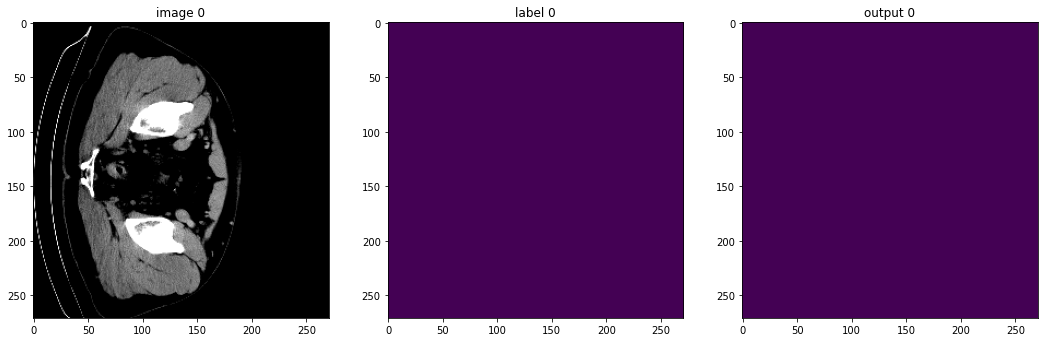

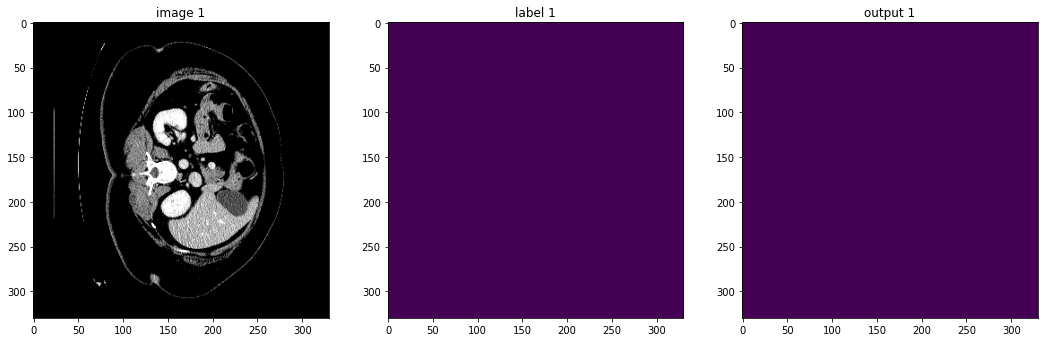

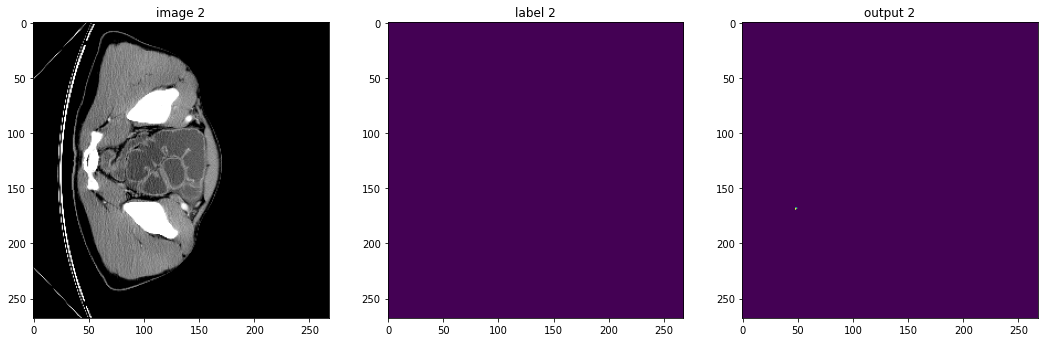

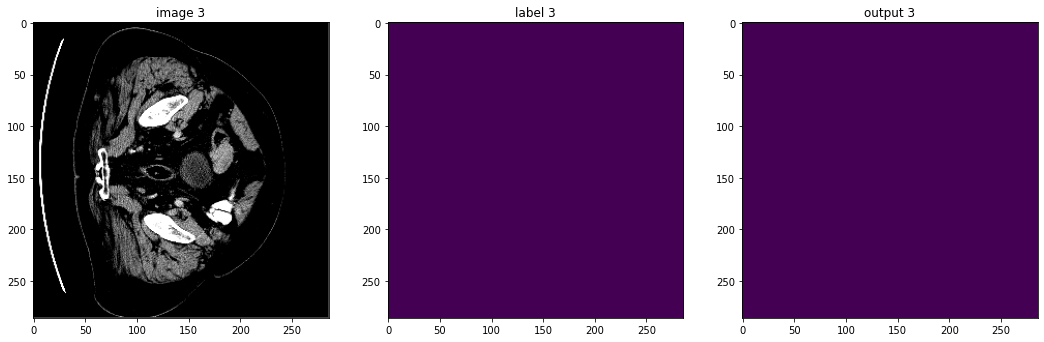

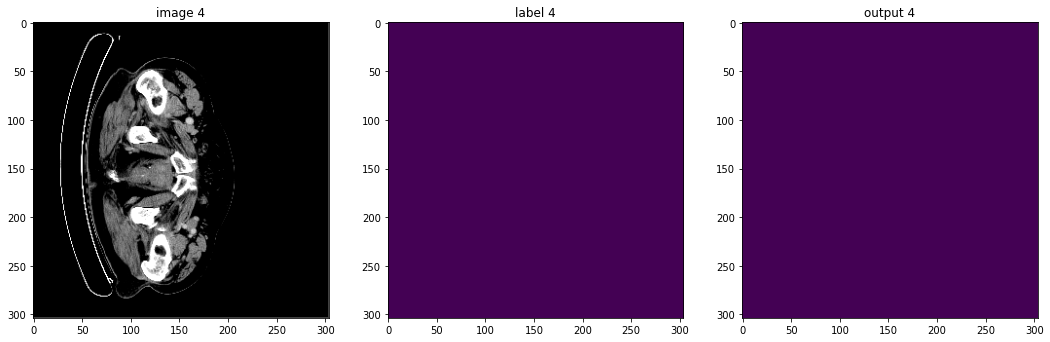

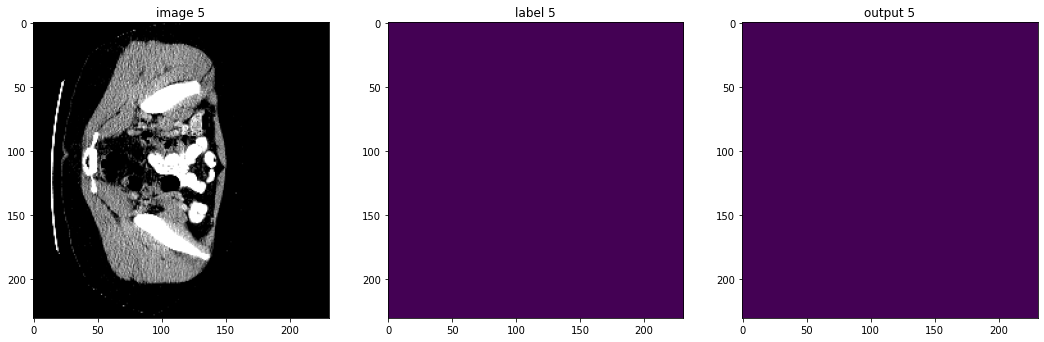

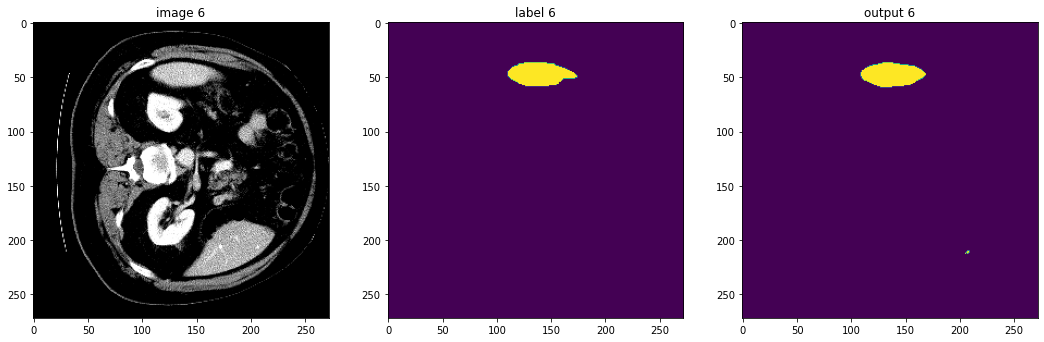

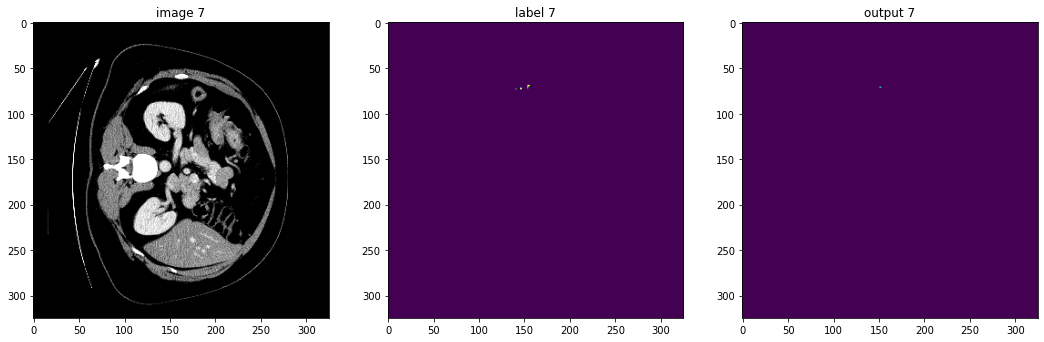

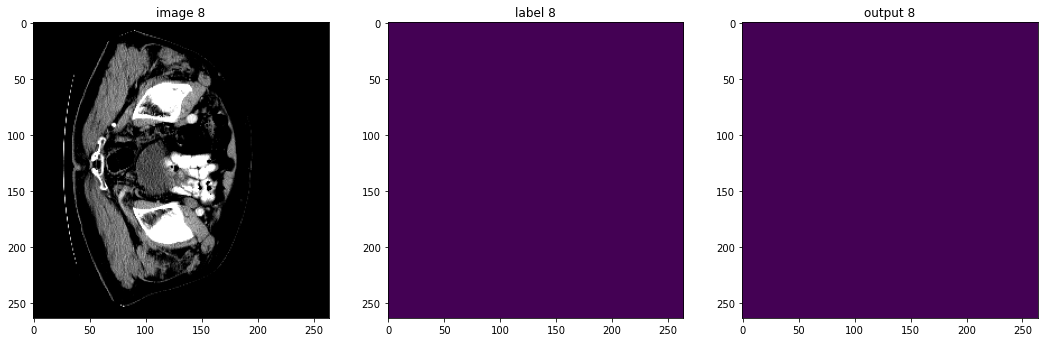

In [15]:
net.eval()
device = torch.device("cuda:0")
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data['image'].to(device), roi_size, sw_batch_size, net)
        # plot the slice [:, :, 50]
        plt.figure('check', (18, 6))
        plt.subplot(1, 3, 1)
        plt.title('image ' + str(i))
        plt.imshow(val_data['image'][0, 0, :, :, 50], cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title('label ' + str(i))
        plt.imshow(val_data['label'][0, 0, :, :, 50])
        plt.subplot(1, 3, 3)
        plt.title('output ' + str(i))
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 50])
        plt.show()